In [559]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

df = pd.read_csv('/Users/p.devine/Documents/GitHub/Academic-Success-Predictor/data/df_vif_cleaned.csv')

X = df.drop(columns=['result_pass'])

y = df['result_pass'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.6846
Confusion Matrix:
[[28 29]
 [12 61]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.49      0.58        57
           1       0.68      0.84      0.75        73

    accuracy                           0.68       130
   macro avg       0.69      0.66      0.66       130
weighted avg       0.69      0.68      0.67       130



In [560]:
# Train a logistic regression model with L1 regularization
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_l1.fit(X_train, y_train)

importance = np.abs(model_l1.coef_).flatten()
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
print(feature_importance.sort_values(by='Importance', ascending=False))

#L1 (lasso) Regularisation to see which features matters most

              Feature  Importance
8              higher    1.842805
2            failures    1.679980
3           schoolsup    1.309515
20       Mjob_at_home    0.981454
15          school_MS    0.912887
32    guardian_mother    0.528253
6          activities    0.485705
16              sex_M    0.443535
1           studytime    0.390930
11               Dalc    0.322640
29        reason_home    0.318193
17          address_U    0.274495
26      Fjob_services    0.265997
23       Mjob_teacher    0.122505
18        famsize_LE3    0.113015
24       Fjob_at_home    0.098904
0          traveltime    0.097200
13             health    0.096968
9            internet    0.091710
27       Fjob_teacher    0.087895
5                paid    0.087121
30  reason_reputation    0.080243
14           absences    0.071870
28      reason_course    0.068867
4              famsup    0.063059
12               Walc    0.033820
7             nursery    0.020291
25        Fjob_health    0.000000
22      Mjob_s

In [561]:
print(df["result_pass"].value_counts())

result_pass
1    348
0    301
Name: count, dtype: int64


In [562]:
df2 = df.drop(columns = [ 'famsup', 'Fjob_health', 'Pstatus_T', 'nursery', 'reason_reputation', 'romantic', 'Walc', 'guardian_father', 'Mjob_health', 'Mjob_services', 'reason_course', 
                         'reason_reputation'])
X = df2.drop(columns=['result_pass'])
y = df2['result_pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_smote, y_train_smote)

y_pred_best = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))


Accuracy: 0.7230769230769231
Confusion Matrix:
 [[33 24]
 [12 61]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.58      0.65        57
           1       0.72      0.84      0.77        73

    accuracy                           0.72       130
   macro avg       0.73      0.71      0.71       130
weighted avg       0.72      0.72      0.72       130



In [564]:
misclassified = X_test[y_test != y_pred_best]
misclassified['actual_label'] = y_test[y_test != y_pred_best]
misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]

print(misclassified.describe())
print(misclassified.groupby('actual_label').mean())

       traveltime  studytime   failures  schoolsup       paid  activities  \
count   36.000000  36.000000  36.000000  36.000000  36.000000   36.000000   
mean     1.472222   1.972222   0.055556   0.194444   0.027778    0.361111   
std      0.736250   0.909823   0.232311   0.401386   0.166667    0.487136   
min      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
25%      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
50%      1.000000   2.000000   0.000000   0.000000   0.000000    0.000000   
75%      2.000000   2.000000   0.000000   0.000000   0.000000    1.000000   
max      4.000000   4.000000   1.000000   1.000000   1.000000    1.000000   

       higher   internet       Dalc    health  ...  famsize_LE3  Mjob_at_home  \
count    36.0  36.000000  36.000000  36.00000  ...    36.000000     36.000000   
mean      1.0   0.777778   1.444444   3.75000  ...     0.388889      0.166667   
std       0.0   0.421637   0.734631   1.48083  ...     0.494413

/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_33149/2595635832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['actual_label'] = y_test[y_test != y_pred_best]
/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_33149/2595635832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]


In [565]:
df2['studytime_failures'] = df2['studytime'] * df2['failures']
df2['paid_schoolsup'] = df2['paid'] * df2['schoolsup']
df2['health_absences'] = df2['health'] * df2['absences']
df2['absences_studytime'] = df2['absences'] * df2['studytime']
df2['Dalc_health'] = df2['Dalc'] * df2['health']
df2['traveltime_schoolsup'] = df2['traveltime'] * df2['schoolsup']

X = df2.drop(columns=['result_pass'])
y = df2['result_pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7307692307692307
Confusion Matrix:
 [[33 24]
 [11 62]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.58      0.65        57
           1       0.72      0.85      0.78        73

    accuracy                           0.73       130
   macro avg       0.74      0.71      0.72       130
weighted avg       0.73      0.73      0.72       130



In [568]:
classifier = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

kfold = KFold(5, shuffle = True, random_state =42)
for i, (train_index, test_index) in enumerate(kfold.split(X,y)):
    print(f"Fold {i}:")
    print(f" Train: index={train_index}")
    print(f" Test: index={test_index}")

scores = cross_val_score(classifier, X ,y, cv=kfold, scoring = 'accuracy')

average_acc = np.mean(scores)

print(f"Accuracy Score for each fold: {[round(score,4) for score in scores]}")
print(f"Average accuracy across 10 folds: {average_acc: .2f}")


Fold 0:
 Train: index=[  0   1   3   4   5   7   8   9  11  12  13  14  15  16  17  18  19  20
  21  22  23  25  26  27  28  29  32  33  34  35  36  37  38  40  42  43
  45  46  47  48  50  51  52  53  57  58  59  61  62  64  66  67  68  71
  73  74  75  79  80  83  84  85  87  88  89  91  92  93  94  95  96  97
  98  99 100 102 103 104 105 106 107 111 112 113 114 115 116 117 119 120
 121 122 123 124 125 126 127 128 129 130 134 136 137 138 139 140 141 142
 143 144 146 147 149 150 151 152 153 154 155 156 157 159 160 161 162 164
 166 168 169 170 171 172 173 175 178 179 180 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 205 206 207
 208 211 213 214 216 217 219 221 222 223 224 225 226 227 228 229 230 232
 233 234 235 236 237 238 239 240 241 242 243 245 246 248 250 251 252 253
 254 255 256 258 259 260 261 262 263 266 267 269 270 272 273 274 275 276
 278 279 280 282 283 284 285 286 287 288 289 290 291 293 294 295 296 297
 299 301 302 303 304 305 306 

In [569]:
misclassified = X_test[y_test != y_pred_best]
misclassified['actual_label'] = y_test[y_test != y_pred_best]
misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]

print(misclassified.describe())
print(misclassified.groupby('actual_label').mean())

       traveltime  studytime   failures  schoolsup       paid  activities  \
count   36.000000  36.000000  36.000000  36.000000  36.000000   36.000000   
mean     1.472222   1.972222   0.055556   0.194444   0.027778    0.361111   
std      0.736250   0.909823   0.232311   0.401386   0.166667    0.487136   
min      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
25%      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
50%      1.000000   2.000000   0.000000   0.000000   0.000000    0.000000   
75%      2.000000   2.000000   0.000000   0.000000   0.000000    1.000000   
max      4.000000   4.000000   1.000000   1.000000   1.000000    1.000000   

       higher   internet       Dalc    health  ...  reason_home  \
count    36.0  36.000000  36.000000  36.00000  ...    36.000000   
mean      1.0   0.777778   1.444444   3.75000  ...     0.250000   
std       0.0   0.421637   0.734631   1.48083  ...     0.439155   
min       1.0   0.000000   1.000000   

/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_33149/2595635832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['actual_label'] = y_test[y_test != y_pred_best]
/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_33149/2595635832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_label'] = y_pred_best[y_test != y_pred_best]


In [570]:
X = df2.drop(columns=['result_pass', 'health_absences', 'paid_schoolsup', 'internet', 'Dalc_health', 'absences', 'famsize_LE3'])
y = df2['result_pass']

smote = SMOTE(random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
conf_matrices = []
class_reports = []

for train_index, val_index in kf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_smote, y_train_smote)
    
    y_pred = model.predict(X_val)
    
    accuracies.append(accuracy_score(y_val, y_pred))
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    class_reports.append(classification_report(y_val, y_pred, output_dict=True))

avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = np.mean([report['accuracy'] for report in class_reports])

print("Average Accuracy: {:.4f}".format(avg_accuracy))
print("Average Confusion Matrix:\n", avg_conf_matrix)
print("Average Classification Report (accuracy): {:.4f}".format(avg_class_report))




Average Accuracy: 0.7380
Average Confusion Matrix:
 [[41.4 18.8]
 [15.2 54.4]]
Average Classification Report (accuracy): 0.7380


In [571]:
X = df2.drop(columns=['result_pass', 'health_absences', 'paid_schoolsup', 'internet', 'Dalc_health', 'absences', 'famsize_LE3'])
y = df2['result_pass']

smote = SMOTE(random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'penalty': ['l1', 'l2'],  
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'solver': ['liblinear', 'saga'],  
    'max_iter': [10000, 50000, 100000]  
}

best_params = None
best_score = 0
accuracies = []
conf_matrices = []
class_reports = []

for train_index, val_index in kf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    model = LogisticRegression()
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,  
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_smote, y_train_smote)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_

    best_model = grid_search.best_estimator_
    best_model.fit(X_train_smote, y_train_smote)

    y_pred = best_model.predict(X_val)
    
    accuracies.append(accuracy_score(y_val, y_pred))
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    class_reports.append(classification_report(y_val, y_pred, output_dict=True))

avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = np.mean([report['accuracy'] for report in class_reports])

df_results = pd.DataFrame(grid_search.cv_results_)

top_10_results = df_results[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 
                             'mean_test_score', 'std_test_score', 'rank_test_score']]\
                    .sort_values(by='rank_test_score')\
                    .head(10)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Training Accuracy: {best_score:.4f}")
print(f"Average Test Accuracy: {avg_accuracy:.4f}")
print("Average Confusion Matrix:\n", avg_conf_matrix)
print("Average Classification Report (accuracy): {:.4f}".format(avg_class_report))
print("\nTop 10 Hyperparameter Configurations:\n", top_10_results)


Best Hyperparameters: {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
Best Training Accuracy: 0.7334
Average Test Accuracy: 0.7318
Average Confusion Matrix:
 [[40.6 19.6]
 [15.2 54.4]]
Average Classification Report (accuracy): 0.7318

Top 10 Hyperparameter Configurations:
    param_penalty  param_C param_solver  param_max_iter  mean_test_score  \
23            l2     0.01         saga          100000         0.733367   
19            l2     0.01         saga           50000         0.733367   
15            l2     0.01         saga           10000         0.733367   
22            l2     0.01    liblinear          100000         0.733316   
18            l2     0.01    liblinear           50000         0.733316   
14            l2     0.01    liblinear           10000         0.733316   
34            l2     0.10    liblinear          100000         0.711077   
30            l2     0.10    liblinear           50000         0.711077   
26            l2     0.10    libl

In [572]:
misclassified = X_val[y_val != y_pred]
misclassified['actual'] = y_val[y_val != y_pred]
misclassified['predicted'] = y_pred[y_val != y_pred]

print(misclassified.describe())
print(misclassified.groupby('actual').mean())


       traveltime  studytime   failures  schoolsup       paid  activities  \
count   41.000000  41.000000  41.000000  41.000000  41.000000   41.000000   
mean     1.634146   1.731707   0.048780   0.073171   0.048780    0.439024   
std      0.829340   0.742442   0.218085   0.263652   0.218085    0.502433   
min      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
25%      1.000000   1.000000   0.000000   0.000000   0.000000    0.000000   
50%      1.000000   2.000000   0.000000   0.000000   0.000000    0.000000   
75%      2.000000   2.000000   0.000000   0.000000   0.000000    1.000000   
max      4.000000   4.000000   1.000000   1.000000   1.000000    1.000000   

          higher       Dalc     health  school_MS  ...  Fjob_at_home  \
count  41.000000  41.000000  41.000000  41.000000  ...     41.000000   
mean    0.926829   1.585366   3.439024   0.414634  ...      0.097561   
std     0.263652   0.999390   1.342549   0.498779  ...      0.300406   
min     0.000000  

/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_33149/844391059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['actual'] = y_val[y_val != y_pred]
/var/folders/q4/1dcp4b254v1cnyw2ypd6phl00000gn/T/ipykernel_33149/844391059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted'] = y_pred[y_val != y_pred]


In [573]:
X = df2.drop(columns=['result_pass', 'health_absences', 'paid_schoolsup', 'internet', 'Dalc_health', 'absences', 'famsize_LE3', 
                      'traveltime', 'higher'])
y = df2['result_pass']

smote = SMOTE(random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'penalty': ['l1', 'l2'],  
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'solver': ['liblinear', 'saga'],  
    'max_iter': [10000, 50000, 100000]  
}

best_params = None
best_score = 0
accuracies = []
conf_matrices = []
class_reports = []

for train_index, val_index in kf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    model = LogisticRegression()
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,  
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_smote, y_train_smote)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_

    best_model = grid_search.best_estimator_
    best_model.fit(X_train_smote, y_train_smote)

    y_pred = best_model.predict(X_val)
    
    accuracies.append(accuracy_score(y_val, y_pred))
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    class_reports.append(classification_report(y_val, y_pred, output_dict=True))

avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = np.mean([report['accuracy'] for report in class_reports])

df_results = pd.DataFrame(grid_search.cv_results_)

top_10_results = df_results[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 
                             'mean_test_score', 'std_test_score', 'rank_test_score']]\
                    .sort_values(by='rank_test_score')\
                    .head(10)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Training Accuracy: {best_score:.4f}")
print(f"Average Test Accuracy: {avg_accuracy:.4f}")
print("Average Confusion Matrix:\n", avg_conf_matrix)
print("Average Classification Report (accuracy): {:.4f}".format(avg_class_report))
print("\nTop 10 Hyperparameter Configurations:\n", top_10_results)

Best Hyperparameters: {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Training Accuracy: 0.7389
Average Test Accuracy: 0.7426
Average Confusion Matrix:
 [[41.  19.2]
 [14.2 55.4]]
Average Classification Report (accuracy): 0.7426

Top 10 Hyperparameter Configurations:
    param_penalty  param_C param_solver  param_max_iter  mean_test_score  \
22            l2     0.01    liblinear          100000         0.738940   
18            l2     0.01    liblinear           50000         0.738940   
14            l2     0.01    liblinear           10000         0.738940   
23            l2     0.01         saga          100000         0.731583   
19            l2     0.01         saga           50000         0.731583   
15            l2     0.01         saga           10000         0.731583   
34            l2     0.10    liblinear          100000         0.718451   
30            l2     0.10    liblinear           50000         0.718451   
26            l2     0.10   

Final Model Test Accuracy: 0.7308
Final Confusion Matrix:
 [[34 23]
 [12 61]]
Final Classification Report (accuracy): 0.7308


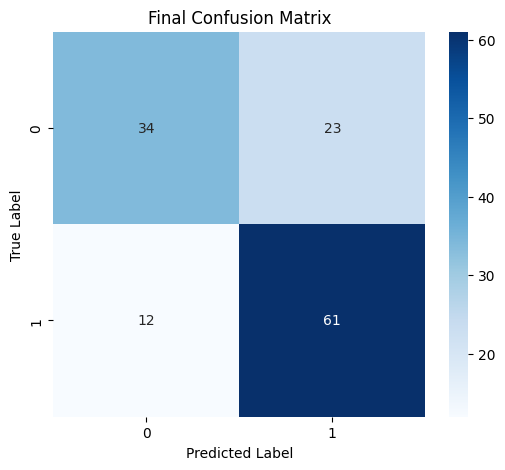

In [574]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

final_model = LogisticRegression(
    penalty=best_params['penalty'], 
    C=best_params['C'], 
    solver=best_params['solver'], 
    max_iter=best_params['max_iter']
)

final_model.fit(X_train_smote, y_train_smote)

y_pred_final = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Model Test Accuracy: {final_accuracy:.4f}")

cm_final = confusion_matrix(y_test, y_pred_final)
print("Final Confusion Matrix:\n", cm_final)

class_report_final = classification_report(y_test, y_pred_final, output_dict=True)
print("Final Classification Report (accuracy): {:.4f}".format(class_report_final['accuracy']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Final Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

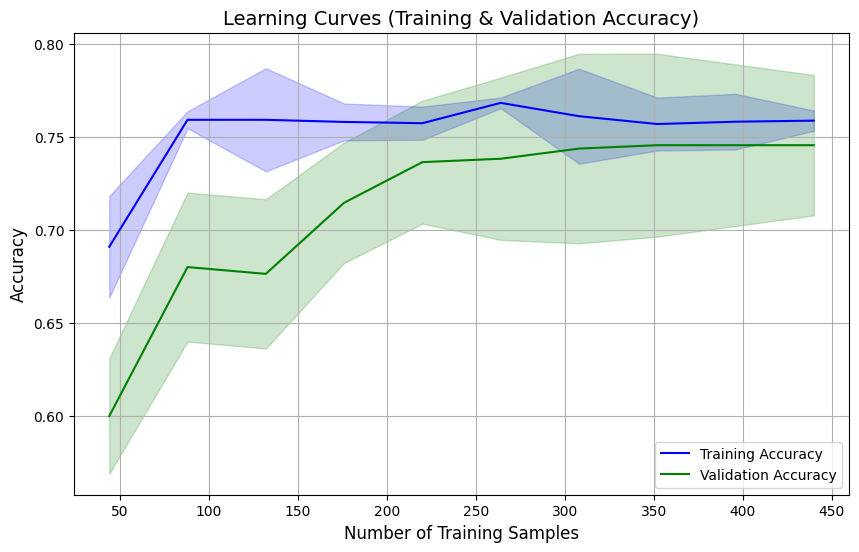

In [575]:
train_sizes, train_scores, val_scores = learning_curve(
    final_model, 
    X_train_smote, 
    y_train_smote, 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5,  
    n_jobs=-1,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='green')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.2)

plt.title('Learning Curves (Training & Validation Accuracy)', fontsize=14)
plt.xlabel('Number of Training Samples', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

plt.show()
